In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-train-1lakh/Train_data_1L.csv
/kaggle/input/quora-test-1lakh/Test_data_1L.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

!pip install fuzzywuzzy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import re
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
import nltk
import time
from matplotlib.pyplot import figure
#from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MinMaxScaler
from joblib import dump, load
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
# import optuna
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import warnings
import gc
from sklearn.model_selection import cross_val_score
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

import optuna
from optuna import Trial, visualization

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
df=pd.read_csv('/kaggle/input/quora-train-1lakh/Train_data_1L.csv')
df.head()

test_data=pd.read_csv('/kaggle/input/quora-test-1lakh/Test_data_1L.csv')
test_data.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [6]:
df.shape

(100000, 6)

In [7]:
test_data.shape

(100000, 3)

In [8]:
df=reduce_mem_usage(df)

Memory usage after optimization is: 2.77 MB
Decreased by 39.6%


In [9]:
test_data=reduce_mem_usage(test_data)

Memory usage after optimization is: 1.91 MB
Decreased by 16.7%


In [10]:
df['is_duplicate'].value_counts(normalize=True)

0    0.62746
1    0.37254
Name: is_duplicate, dtype: float64

In [11]:
df=df.dropna()
df.shape

(100000, 6)

<AxesSubplot:>

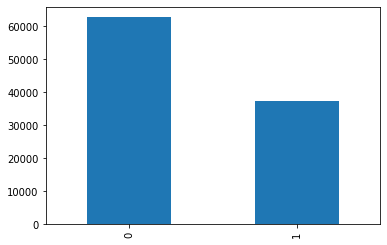

In [12]:
df_is_dup=df['is_duplicate'].value_counts()
df_is_dup.plot.bar()

In [13]:
qids = np.append(df.qid1.values,df.qid2.values)
print(len(set(qids)))
print(len(qids))

165931
200000


In [14]:
print(df.question1.apply(len).min())
print(df.loc[df.question1.apply(len).argmin()])
print(df.question2.apply(len).min())
print(df.loc[df.question2.apply(len).argmin()])


1
id                                                           3306
qid1                                                         6553
qid2                                                         6554
question1                                                       .
question2       Why is Cornell's endowment the lowest in the I...
is_duplicate                                                    0
Name: 3306, dtype: object
1
id                                                          47056
qid1                                                        84067
qid2                                                        84068
question1       Is there anywhere in the world offering pain m...
question2                                                       ?
is_duplicate                                                    0
Name: 47056, dtype: object


In [15]:
def preprocess_text(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'").replace("won't", "will not")\
                           .replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    x = re.sub(r"http\S+", "", x)
    x = re.sub('\W', ' ', x)
    
    lemmatizer = WordNetLemmatizer()
    x = lemmatizer.lemmatize(x)
    bfs = BeautifulSoup(x)
    x = bfs.get_text()
    x = x.strip()
    return x

In [16]:
def data_cleaning(data):
    newdata = pd.DataFrame()
    newdata['question1_final'] = data['question1'].apply(preprocess_text)
    newdata['question2_final'] = data['question2'].apply(preprocess_text)
    return newdata

In [17]:
nltk.download('omw-1.4')
train_data=data_cleaning(df)

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [18]:
train_data.head()

,question1_final,question2_final
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...
1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...
3,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math i...
4,which one dissolve in water quikly sugar salt...,which fish would survive in salt water


In [19]:
test_data=data_cleaning(test_data)
test_data.head()

,question1_final,question2_final
0,how does the surface pro himself 4 compare wit...,why did microsoft choose core m3 and not core ...
1,should i have a hair transplant at age 24 how...,how much cost does hair transplant require
2,what but is the best way to send money from ch...,what you send money to china
3,which food not emulsifiers,what foods fibre
4,how aberystwyth start reading,how their can i start reading


In [20]:
def doesMatch (q, match):
    q1, q2 = q['question1_final'], q['question2_final']
    q1 = q1.split()
    q2 = q2.split()
    if len(q1)>0 and len(q2)>0 and q1[match]==q2[match]:
        return 1
    else:
        return 0

In [21]:
def feature_extract(data):
    data['q1_char_num'] = data.question1_final.apply(len)
    data['q2_char_num'] = data.question2_final.apply(len)
    data['q1_word_num'] = data.question1_final.apply(lambda x: len(x.split()))
    data['q2_word_num'] = data.question2_final.apply(lambda x: len(x.split()))
    
    data['total_word_num'] = data['q1_word_num'] + data['q2_word_num']
    data['differ_word_num'] = abs(data['q1_word_num'] - data['q2_word_num'])
    data['same_first_word'] = data.apply(lambda x: doesMatch(x, 0) ,axis=1)
    data['same_last_word'] = data.apply(lambda x: doesMatch(x, -1) ,axis=1)
    data['total_unique_word_num'] = data.apply(lambda x: len(set(x.question1_final.split()).union(set(x.question2_final.split()))) ,axis=1)
    data['total_unique_word_withoutstopword_num'] = data.apply(lambda x: len(set(x.question1_final.split()).union(set(x.question2_final.split())) - set(stopwords.words('english'))) ,axis=1)
    data['total_unique_word_num_ratio'] = data['total_unique_word_num'] / data['total_word_num']
    
    data['common_word_num'] = data.apply(lambda x: len(set(x.question1_final.split()).intersection(set(x.question2_final.split()))) ,axis=1)
    data['common_word_ratio'] = data['common_word_num'] / data['total_unique_word_num']
    data['common_word_ratio_min'] = data['common_word_num'] / data.apply(lambda x: min(len(set(x.question1_final.split())), len(set(x.question2_final.split()))) ,axis=1) 
    data['common_word_ratio_max'] = data['common_word_num'] / data.apply(lambda x: max(len(set(x.question1_final.split())), len(set(x.question2_final.split()))) ,axis=1) 
    
    data['common_word_withoutstopword_num'] = data.apply(lambda x: len(set(x.question1_final.split()).intersection(set(x.question2_final.split())) - set(stopwords.words('english'))) ,axis=1)
    data['common_word_withoutstopword_ratio'] = data['common_word_withoutstopword_num'] / data['total_unique_word_withoutstopword_num']
    data['common_word_withoutstopword_ratio_min'] = data['common_word_withoutstopword_num'] / data.apply(lambda x: min(len(set(x.question1_final.split()) - set(stopwords.words('english'))), len(set(x.question2_final.split()) - set(stopwords.words('english')))) ,axis=1) 
    data['common_word_withoutstopword_ratio_max'] = data['common_word_withoutstopword_num'] / data.apply(lambda x: max(len(set(x.question1_final.split()) - set(stopwords.words('english'))), len(set(x.question2_final.split()) - set(stopwords.words('english')))) ,axis=1) 
    
    data["fuzz_ratio"] = data.apply(lambda x: fuzz.ratio(x.question1_final, x.question2_final), axis=1)
    data["fuzz_partial_ratio"] = data.apply(lambda x: fuzz.partial_ratio(x.question1_final, x.question2_final), axis=1)
    data["fuzz_token_set_ratio"] = data.apply(lambda x: fuzz.token_set_ratio(x.question1_final, x.question2_final), axis=1)
    data["fuzz_token_sort_ratio"] = data.apply(lambda x: fuzz.token_sort_ratio(x.question1_final, x.question2_final), axis=1)
    data.fillna(0, inplace=True)
    return data

In [22]:
train_data = feature_extract(train_data)

In [23]:
test_data = feature_extract(test_data)
test_data.head()

,question1_final,question2_final,q1_char_num,q2_char_num,q1_word_num,q2_word_num,total_word_num,differ_word_num,same_first_word,same_last_word,...,common_word_ratio_min,common_word_ratio_max,common_word_withoutstopword_num,common_word_withoutstopword_ratio,common_word_withoutstopword_ratio_min,common_word_withoutstopword_ratio_max,fuzz_ratio,fuzz_partial_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
0,how does the surface pro himself 4 compare wit...,why did microsoft choose core m3 and not core ...,56,67,11,14,25,3,0,0,...,0.300000,0.230769,3,0.272727,0.6,0.333333,46,45,58,55
1,should i have a hair transplant at age 24 how...,how much cost does hair transplant require,65,42,14,7,21,7,0,0,...,0.714286,0.357143,4,0.500000,0.8,0.571429,49,57,82,58
2,what but is the best way to send money from ch...,what you send money to china,59,28,14,6,20,8,1,0,...,0.833333,0.416667,3,0.500000,1.0,0.500000,60,82,92,55
3,which food not emulsifiers,what foods fibre,26,16,4,3,7,1,0,0,...,0.000000,0.000000,0,0.000000,0.0,0.000000,52,56,52,52
4,how aberystwyth start reading,how their can i start reading,31,29,4,6,10,2,1,1,...,0.750000,0.500000,2,0.666667,1.0,0.666667,70,66,74,66


In [24]:
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer
modelST = SentenceTransformer('paraphrase-MiniLM-L6-v2')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.8 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=3e8b6e7eb903687676e25560c3d35e00d22396ebbd4c08cb7ebe1e112a3dacc1
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence_transformers


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [25]:
#sentences = ['The quick brown fox jumps over the lazy dog', 
             #'Dogs are a popular household pet around the world']
#embeddings = modelST.encode(sentences)
#for embedding in embeddings:
 #print(embedding)

In [26]:
#df_samp=pd.DataFrame({'Sentence':["My name is Kshitij","I love to play cricket"]})
#df_samp

In [27]:
#df_samp['emb']=modelST.encode(sent).tolist()
#df_samp

In [28]:
#df_samp=df_samp['emb'].apply(pd.Series)

In [29]:
#df_samp.head()

In [30]:
#df_samp.shape

In [31]:
train_data.head()

,question1_final,question2_final,q1_char_num,q2_char_num,q1_word_num,q2_word_num,total_word_num,differ_word_num,same_first_word,same_last_word,...,common_word_ratio_min,common_word_ratio_max,common_word_withoutstopword_num,common_word_withoutstopword_ratio,common_word_withoutstopword_ratio_min,common_word_withoutstopword_ratio_max,fuzz_ratio,fuzz_partial_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,65,56,14,12,26,2,1,0,...,1.000000,0.916667,5,0.833333,1.0,0.833333,93,100,100,93
1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,50,87,10,15,25,5,1,0,...,0.700000,0.500000,4,0.363636,0.8,0.400000,66,74,86,63
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,72,58,14,10,24,4,1,0,...,0.400000,0.285714,2,0.222222,0.4,0.333333,54,53,66,66
3,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math i...,49,64,11,13,24,2,0,0,...,0.000000,0.000000,0,0.000000,0.0,0.000000,35,39,36,36
4,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,75,38,13,7,20,6,1,0,...,0.571429,0.307692,2,0.153846,0.4,0.200000,46,55,67,47


In [32]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [33]:
train_data=reduce_mem_usage(train_data)

Memory usage after optimization is: 7.83 MB
Decreased by 64.2%


In [34]:
sentences_list=train_data['question1_final'].to_list()


In [35]:
sentences_list_2=train_data['question2_final'].to_list()

In [36]:
train_data['question_1_embed']=modelST.encode(sentences_list).tolist()
train_data['question_2_embed']=modelST.encode(sentences_list_2).tolist()
train_data.head()


Batches:   0%|          | 0/3125 [00:00<?, ?it/s]

Batches:   0%|          | 0/3125 [00:00<?, ?it/s]

,question1_final,question2_final,q1_char_num,q2_char_num,q1_word_num,q2_word_num,total_word_num,differ_word_num,same_first_word,same_last_word,...,common_word_withoutstopword_num,common_word_withoutstopword_ratio,common_word_withoutstopword_ratio_min,common_word_withoutstopword_ratio_max,fuzz_ratio,fuzz_partial_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,question_1_embed,question_2_embed
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,65,56,14,12,26,2,1,0,...,5,0.833496,1.000000,0.833496,93,100,100,93,"[0.0122295580804348, -0.5363558530807495, -0.5...","[-0.04522165283560753, -0.3243589997291565, -0..."
1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,50,87,10,15,25,5,1,0,...,4,0.363525,0.799805,0.399902,66,74,86,63,"[-0.4151861369609833, 0.7419866323471069, -0.7...","[-0.35709497332572937, 0.4482213854789734, -0...."
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,72,58,14,10,24,4,1,0,...,2,0.222168,0.399902,0.333252,54,53,66,66,"[-0.3365289270877838, 0.11859980970621109, -0....","[-0.3322516083717346, -0.4099831283092499, -0...."
3,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math i...,49,64,11,13,24,2,0,0,...,0,0.000000,0.000000,0.000000,35,39,36,36,"[0.22098174691200256, -0.028938723728060722, 0...","[0.18500512838363647, 0.608160138130188, 0.261..."
4,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,75,38,13,7,20,6,1,0,...,2,0.153809,0.399902,0.199951,46,55,67,47,"[-0.7687870264053345, -0.02330757863819599, -0...","[-0.5300846099853516, 0.10732445120811462, 0.0..."


In [37]:
train_data.shape

(100000, 27)

In [38]:
train_data=reduce_mem_usage(train_data)

Memory usage after optimization is: 9.36 MB
Decreased by 0.0%


In [39]:
train_data_updated = train_data['question_1_embed'].apply(pd.Series)
train_data_updated.head()
train_data_updated=reduce_mem_usage(train_data_updated)

Memory usage after optimization is: 76.02 MB
Decreased by 74.3%


In [40]:
train_data_updated_2=train_data['question_2_embed'].apply(pd.Series)
train_data_updated_2.head()
train_data_updated_2=reduce_mem_usage(train_data_updated_2)

Memory usage after optimization is: 76.02 MB
Decreased by 74.3%


In [41]:
train_data.columns

Index(['question1_final', 'question2_final', 'q1_char_num', 'q2_char_num',
       'q1_word_num', 'q2_word_num', 'total_word_num', 'differ_word_num',
       'same_first_word', 'same_last_word', 'total_unique_word_num',
       'total_unique_word_withoutstopword_num', 'total_unique_word_num_ratio',
       'common_word_num', 'common_word_ratio', 'common_word_ratio_min',
       'common_word_ratio_max', 'common_word_withoutstopword_num',
       'common_word_withoutstopword_ratio',
       'common_word_withoutstopword_ratio_min',
       'common_word_withoutstopword_ratio_max', 'fuzz_ratio',
       'fuzz_partial_ratio', 'fuzz_token_set_ratio', 'fuzz_token_sort_ratio',
       'question_1_embed', 'question_2_embed'],
      dtype='object')

In [42]:
train_data_updated_3=train_data[[ 'q1_char_num', 'q2_char_num',
       'q1_word_num', 'q2_word_num', 'total_word_num', 'differ_word_num',
       'same_first_word', 'same_last_word', 'total_unique_word_num',
       'total_unique_word_withoutstopword_num', 'total_unique_word_num_ratio',
       'common_word_num', 'common_word_ratio', 'common_word_ratio_min',
       'common_word_ratio_max', 'common_word_withoutstopword_num',
       'common_word_withoutstopword_ratio',
       'common_word_withoutstopword_ratio_min',
       'common_word_withoutstopword_ratio_max', 'fuzz_ratio',
       'fuzz_partial_ratio', 'fuzz_token_set_ratio', 'fuzz_token_sort_ratio']]
train_data_updated_3.head()

,q1_char_num,q2_char_num,q1_word_num,q2_word_num,total_word_num,differ_word_num,same_first_word,same_last_word,total_unique_word_num,total_unique_word_withoutstopword_num,...,common_word_ratio_min,common_word_ratio_max,common_word_withoutstopword_num,common_word_withoutstopword_ratio,common_word_withoutstopword_ratio_min,common_word_withoutstopword_ratio_max,fuzz_ratio,fuzz_partial_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
0,65,56,14,12,26,2,1,0,12,6,...,1.000000,0.916504,5,0.833496,1.000000,0.833496,93,100,100,93
1,50,87,10,15,25,5,1,0,17,11,...,0.700195,0.500000,4,0.363525,0.799805,0.399902,66,74,86,63
2,72,58,14,10,24,4,1,0,20,9,...,0.399902,0.285645,2,0.222168,0.399902,0.333252,54,53,66,66
3,49,64,11,13,24,2,0,0,20,9,...,0.000000,0.000000,0,0.000000,0.000000,0.000000,35,39,36,36
4,75,38,13,7,20,6,1,0,16,13,...,0.571289,0.307617,2,0.153809,0.399902,0.199951,46,55,67,47


In [43]:
train_data_final=pd.concat([train_data_updated_3, train_data_updated,train_data_updated_2],axis=1)

In [44]:
#train_data_final=reduce_mem_usage(train_data_final)

In [45]:

train_data_final.head()

,q1_char_num,q2_char_num,q1_word_num,q2_word_num,total_word_num,differ_word_num,same_first_word,same_last_word,total_unique_word_num,total_unique_word_withoutstopword_num,...,374,375,376,377,378,379,380,381,382,383
0,65,56,14,12,26,2,1,0,12,6,...,0.323242,-0.136597,-0.102234,0.041687,-0.076721,-0.195435,-0.166260,-0.909668,-0.655762,0.302734
1,50,87,10,15,25,5,1,0,17,11,...,0.844727,0.227661,0.322754,0.135620,-0.411865,-0.044250,0.343994,-0.264648,0.041473,0.012054
2,72,58,14,10,24,4,1,0,20,9,...,0.340576,-0.631836,-0.461426,-0.135864,-0.326172,0.567383,-0.209229,0.107849,-0.020416,-0.104492
3,49,64,11,13,24,2,0,0,20,9,...,0.481934,-0.603027,0.326904,0.208740,-0.659180,0.118591,-0.496826,-0.060059,0.331055,-0.646484
4,75,38,13,7,20,6,1,0,16,13,...,0.205078,0.804688,-0.030624,0.161743,-0.702148,0.229980,-0.480225,0.037781,0.515625,0.221802


In [46]:
train_data_final.shape

(100000, 791)

In [47]:
df.shape

(100000, 6)

In [48]:
train_data_final_1=train_data_final.to_numpy()
train_data_final_1

array([[ 6.50000000e+01,  5.60000000e+01,  1.40000000e+01, ...,
        -9.09667969e-01, -6.55761719e-01,  3.02734375e-01],
       [ 5.00000000e+01,  8.70000000e+01,  1.00000000e+01, ...,
        -2.64648438e-01,  4.14733887e-02,  1.20544434e-02],
       [ 7.20000000e+01,  5.80000000e+01,  1.40000000e+01, ...,
         1.07849121e-01, -2.04162598e-02, -1.04492188e-01],
       ...,
       [ 3.80000000e+01,  5.70000000e+01,  7.00000000e+00, ...,
        -8.36425781e-01,  2.03247070e-01,  1.13586426e-01],
       [ 5.80000000e+01,  5.90000000e+01,  1.10000000e+01, ...,
        -5.84106445e-02,  5.24902344e-01,  4.57031250e-01],
       [ 4.20000000e+01,  5.10000000e+01,  7.00000000e+00, ...,
        -1.37451172e-01, -6.44531250e-02, -1.22558594e-01]], dtype=float32)

In [49]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_train, y_train = oversample.fit_resample(train_data_final_1, df['is_duplicate'].to_numpy())

In [50]:
X_train.shape

(125492, 791)

In [51]:
y_train.shape

(125492,)

In [52]:
print(np.count_nonzero(y_train == 0))
print(np.count_nonzero(y_train == 1))

62746
62746


In [53]:
test_data.head()

,question1_final,question2_final,q1_char_num,q2_char_num,q1_word_num,q2_word_num,total_word_num,differ_word_num,same_first_word,same_last_word,...,common_word_ratio_min,common_word_ratio_max,common_word_withoutstopword_num,common_word_withoutstopword_ratio,common_word_withoutstopword_ratio_min,common_word_withoutstopword_ratio_max,fuzz_ratio,fuzz_partial_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
0,how does the surface pro himself 4 compare wit...,why did microsoft choose core m3 and not core ...,56,67,11,14,25,3,0,0,...,0.300000,0.230769,3,0.272727,0.6,0.333333,46,45,58,55
1,should i have a hair transplant at age 24 how...,how much cost does hair transplant require,65,42,14,7,21,7,0,0,...,0.714286,0.357143,4,0.500000,0.8,0.571429,49,57,82,58
2,what but is the best way to send money from ch...,what you send money to china,59,28,14,6,20,8,1,0,...,0.833333,0.416667,3,0.500000,1.0,0.500000,60,82,92,55
3,which food not emulsifiers,what foods fibre,26,16,4,3,7,1,0,0,...,0.000000,0.000000,0,0.000000,0.0,0.000000,52,56,52,52
4,how aberystwyth start reading,how their can i start reading,31,29,4,6,10,2,1,1,...,0.750000,0.500000,2,0.666667,1.0,0.666667,70,66,74,66


In [54]:
test_data.shape

(100000, 25)

In [55]:
test_data=test_data.iloc[:75000,:]

In [56]:
test_data=reduce_mem_usage(test_data)

Memory usage after optimization is: 3.50 MB
Decreased by 75.5%


In [57]:
sentences_list=test_data['question1_final'].to_list()
sentences_list_2=test_data['question2_final'].to_list()



test_data['question_1_embed']=modelST.encode(sentences_list).tolist()
test_data['question_2_embed']=modelST.encode(sentences_list_2).tolist()
test_data.head()


Batches:   0%|          | 0/2344 [00:00<?, ?it/s]

Batches:   0%|          | 0/2344 [00:00<?, ?it/s]

,question1_final,question2_final,q1_char_num,q2_char_num,q1_word_num,q2_word_num,total_word_num,differ_word_num,same_first_word,same_last_word,...,common_word_withoutstopword_num,common_word_withoutstopword_ratio,common_word_withoutstopword_ratio_min,common_word_withoutstopword_ratio_max,fuzz_ratio,fuzz_partial_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,question_1_embed,question_2_embed
0,how does the surface pro himself 4 compare wit...,why did microsoft choose core m3 and not core ...,56,67,11,14,25,3,0,0,...,3,0.272705,0.600098,0.333252,46,45,58,55,"[0.23955248296260834, -0.36198022961616516, 0....","[0.34360942244529724, -0.102994903922081, 0.17..."
1,should i have a hair transplant at age 24 how...,how much cost does hair transplant require,65,42,14,7,21,7,0,0,...,4,0.500000,0.799805,0.571289,49,57,82,58,"[-0.0010466240346431732, -0.1535162329673767, ...","[-0.25260430574417114, -0.5278909206390381, 0...."
2,what but is the best way to send money from ch...,what you send money to china,59,28,14,6,20,8,1,0,...,3,0.500000,1.000000,0.500000,60,82,92,55,"[-0.043514009565114975, -0.07662510126829147, ...","[-0.18359361588954926, 0.2447115182876587, -0...."
3,which food not emulsifiers,what foods fibre,26,16,4,3,7,1,0,0,...,0,0.000000,0.000000,0.000000,52,56,52,52,"[-0.24049749970436096, -0.32035109400749207, -...","[0.23294644057750702, -0.6641413569450378, -0...."
4,how aberystwyth start reading,how their can i start reading,31,29,4,6,10,2,1,1,...,2,0.666504,1.000000,0.666504,70,66,74,66,"[0.24994902312755585, -0.027848010882735252, -...","[0.2891940474510193, -0.7665246725082397, -0.4..."


In [58]:
test_data_updated = test_data['question_1_embed'].apply(pd.Series)
test_data_updated.head()
test_data_updated=reduce_mem_usage(test_data_updated)

Memory usage after optimization is: 54.93 MB
Decreased by 75.0%


In [59]:
test_data_updated_2 = test_data['question_2_embed'].apply(pd.Series)
test_data_updated_2.head()
test_data_updated_2=reduce_mem_usage(test_data_updated_2)

Memory usage after optimization is: 54.93 MB
Decreased by 75.0%


In [60]:
test_data_updated_3=test_data[[ 'q1_char_num', 'q2_char_num',
       'q1_word_num', 'q2_word_num', 'total_word_num', 'differ_word_num',
       'same_first_word', 'same_last_word', 'total_unique_word_num',
       'total_unique_word_withoutstopword_num', 'total_unique_word_num_ratio',
       'common_word_num', 'common_word_ratio', 'common_word_ratio_min',
       'common_word_ratio_max', 'common_word_withoutstopword_num',
       'common_word_withoutstopword_ratio',
       'common_word_withoutstopword_ratio_min',
       'common_word_withoutstopword_ratio_max', 'fuzz_ratio',
       'fuzz_partial_ratio', 'fuzz_token_set_ratio', 'fuzz_token_sort_ratio']]
test_data_updated_3.head()

,q1_char_num,q2_char_num,q1_word_num,q2_word_num,total_word_num,differ_word_num,same_first_word,same_last_word,total_unique_word_num,total_unique_word_withoutstopword_num,...,common_word_ratio_min,common_word_ratio_max,common_word_withoutstopword_num,common_word_withoutstopword_ratio,common_word_withoutstopword_ratio_min,common_word_withoutstopword_ratio_max,fuzz_ratio,fuzz_partial_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
0,56,67,11,14,25,3,0,0,20,11,...,0.300049,0.230713,3,0.272705,0.600098,0.333252,46,45,58,55
1,65,42,14,7,21,7,0,0,16,8,...,0.714355,0.357178,4,0.500000,0.799805,0.571289,49,57,82,58
2,59,28,14,6,20,8,1,0,13,6,...,0.833496,0.416748,3,0.500000,1.000000,0.500000,60,82,92,55
3,26,16,4,3,7,1,0,0,7,4,...,0.000000,0.000000,0,0.000000,0.000000,0.000000,52,56,52,52
4,31,29,4,6,10,2,1,1,7,3,...,0.750000,0.500000,2,0.666504,1.000000,0.666504,70,66,74,66


In [61]:
test_data_final=pd.concat([test_data_updated_3, test_data_updated,test_data_updated_2],axis=1)

**RandomForest**

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score

# making 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# defining model
rf = RandomForestClassifier()

# taking positive because cross val score returns -ve values
scores = np.abs(cross_val_score(rf, X_train, y_train, cv=kf, scoring='neg_log_loss'))

# printing the output
print(f"Scores - {scores}\nMean - {sum(scores)/len(scores)}")

Scores - [0.32232791 0.32159775 0.32458337 0.32198951 0.32202974]
Mean - 0.3225056553049602


In [68]:
def Objective(trial):
    params = {
         "n_estimators": trial.suggest_categorical("n_estimators", [200, 350, 500]),
        "max_depth": trial.suggest_categorical("max_depth",[5,7,9,11,13]),
        #"criterion":trial.suggest_categorical("criterion",["log_loss"]),
        "min_samples_split":trial.suggest_int("min_samples_split",2,5,7)
    }
    
    model = RandomForestClassifier(**params)
    
    
    # taking positive because cross val score returns -ve values
    scores = np.abs(cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_log_loss'))
    
    return sum(scores)/len(scores)

In [69]:
study = optuna.create_study(direction="minimize", study_name='RandomForest optimization')
study.optimize(Objective, n_trials=20)

[I 2022-12-25 10:35:32,862] A new study created in memory with name: RandomForest optimization
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
[W 2022-12-25 10:53:19,288] Trial 0 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_23/3643479191.py", line 13, in Objective
    scores = np.abs(cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_log_loss'))
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 520, in cross_val_score
    error_score=error_score,
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation

KeyboardInterrupt: 

In [ ]:
study.best_params

**XGBoost**

In [71]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, cross_val_score

# making 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# defining model
xgbreg = XGBClassifier(tree_method='gpu_hist')

# taking positive because cross val score returns -ve values
scores = np.abs(cross_val_score(xgbreg, X_train, y_train, cv=kf, scoring='neg_log_loss'))

# printing the output
print(f"Scores - {scores}\nMean - {sum(scores)/len(scores)}")

Scores - [0.31308509 0.30644931 0.31609402 0.31289437 0.30968669]
Mean - 0.3116418974177154


In [72]:
def Objective(trial):
    params = {
    #"n_estimators": trial.suggest_categorical("n_estimators", [150, 200, 250, 300]),
        "eta": trial.suggest_loguniform("eta",1e-2,0.1),
        "subsample": trial.suggest_discrete_uniform("subsample", 0.6,1,0.1),
        "min_child_weight": trial.suggest_int("min_child_weight",5,11),
        "colsample_bytree": trial.suggest_discrete_uniform("colsample_bytree", 0.6,1,0.1),
        "max_depth": trial.suggest_categorical("max_depth",[5,7,9,11,13]),
        "random_state": 2021
    }
    
    model = XGBClassifier(**params, tree_method='gpu_hist')
    
    
    # taking positive because cross val score returns -ve values
    scores = np.abs(cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_log_loss'))
    
    return sum(scores)/len(scores)

In [73]:
study = optuna.create_study(direction="minimize", study_name='Xgboost optimization')
study.optimize(Objective, n_trials=20)

[I 2022-12-25 10:54:25,157] A new study created in memory with name: Xgboost optimization
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  impo

In [74]:
study.best_params

{'eta': 0.09888804176940505,
 'subsample': 0.9,
 'min_child_weight': 5,
 'colsample_bytree': 0.8,
 'max_depth': 13}

In [ ]:
xgb_params={'eta': 0.09888804176940505,
 'subsample': 0.9,
 'min_child_weight': 5,
 'colsample_bytree': 0.8,
 'max_depth': 13}